In [1]:
import numpy as np
import struct
from array import array
import pandas as pd
import os
from os.path  import join
import random as rn
from sklearn.neural_network import MLPClassifier
import graphviz
import pydotplus
from IPython.display import Image
from io import StringIO
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import log_loss
import random
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import time
import itertools
import matplotlib as mpl
from sklearn.model_selection import GridSearchCV

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.stats import kurtosis
from sklearn.decomposition import FastICA
from sklearn.random_projection import SparseRandomProjection

In [2]:
"""
Loading in the dataset into a pandas dataframe object.

For the following segments the code snippets were retreved from: https://www.kaggle.com/code/anetakovacheva/interpreting-a-music-genre-classifier
"""

%matplotlib inline

input_path = 'data/musicgenre_datafolder'
file_path = join(input_path, 'music_genre.csv')

music_data = pd.read_csv(file_path)

"""
Cleaning and Pre-Processing all of the data
"""

"""
There are some duplicated data that needs to be cleaned up
"""
music_data.duplicated().any()
duplicated = music_data.duplicated()
music_data[duplicated]
music_data.iloc[9999:10006]
music_data.drop([10000, 10001, 10002, 10003, 10004], inplace = True)

"""
Removing some columns that don't matter or will complicated the training too much
"""
music_data.reset_index(inplace = True)
music_data = music_data.drop(["artist_name", "index", "instance_id", "track_name", "obtained_date"], axis = 1)

"""
Normalizing the music data such that it removes invalid values for 'tempo' and converts
the column values into a float
"""
music_data = music_data.drop(music_data[music_data["tempo"] == "?"].index)
music_data["tempo"] = music_data["tempo"].astype("float")
music_data["tempo"] = np.around(music_data["tempo"], decimals = 2)

"""
Encoding the columns that are strings with LabelEncoder since this will mess
up the algorithms that require numeric values
"""
key_encoder = LabelEncoder()
mode_encoder = LabelEncoder()
music_data["key"] = key_encoder.fit_transform(music_data["key"])
music_data["mode"] = mode_encoder.fit_transform(music_data["mode"])

"""
Separating out the column features from the music genre label
"""
music_features = music_data.drop("music_genre", axis = 1)
music_labels = music_data["music_genre"]

print(music_data)
print(np.unique(music_labels))
print(len(np.unique(music_labels)))

"""
Scaling the features out into a scale centered around 0 with a standard deviation of 1
"""
scaler = StandardScaler()
music_features_scaled = scaler.fit_transform(music_features)
# print(music_features_scaled[0])

"""
Splitting the data into Training and Testing Data Sets
"""
train_features, test_features, train_labels, test_labels = train_test_split(
    music_features_scaled, music_labels, test_size = 0.1, stratify = music_labels)


       popularity  acousticness  danceability  duration_ms  energy  \
0            27.0       0.00468         0.652         -1.0   0.941   
1            31.0       0.01270         0.622     218293.0   0.890   
2            28.0       0.00306         0.620     215613.0   0.755   
3            34.0       0.02540         0.774     166875.0   0.700   
4            32.0       0.00465         0.638     222369.0   0.587   
...           ...           ...           ...          ...     ...   
49995        59.0       0.03340         0.913         -1.0   0.574   
49996        72.0       0.15700         0.709     251860.0   0.362   
49997        51.0       0.00597         0.693     189483.0   0.763   
49998        65.0       0.08310         0.782     262773.0   0.472   
49999        67.0       0.10200         0.862     267267.0   0.642   

       instrumentalness  key  liveness  loudness  mode  speechiness   tempo  \
0               0.79200    1     0.115    -5.201     1       0.0748  100.89   
1

In [38]:
"""
Setting up seed values for reproducability
"""
seed = 1234
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [39]:
"""
Getting the size values for the training and testing dataset
"""
size_train_samples = np.shape(train_features)[0]
size_test_samples = np.shape(test_features)[0]

In [40]:
number_of_epochs = 150

In [41]:
"""
Running the clustering algorithm to find labels to add as another feature to the dataset
"""
covariance_type = "full"
tol = 1e-3
reg_covar = 1e-6
max_iter = 100
n_init = 1
init_params = "kmeans"

gmfinal = GaussianMixture(
        n_components = 10,
        covariance_type = covariance_type,
        tol = tol,
        reg_covar = reg_covar,
        max_iter = max_iter,
        init_params = init_params,
        n_init = n_init,
        random_state = seed
    )
    
gmfinal.fit(train_features)
gm_train_fit_labels = gmfinal.predict(train_features)
gm_test_fit_labels = gmfinal.predict(test_features)

In [42]:
"""
Adding the labels as a column to the train / test data
"""
gm_train_data = np.append(train_features, gm_train_fit_labels[:, None], axis=1)
gm_test_data = np.append(test_features, gm_test_fit_labels[:, None], axis=1)

In [43]:
"""
Run the Neural Network algorithm with the clustering data.
"""

"""
Actually training the MLP Classifier to generate the graph for the learning graph visualizer.
This should utilize the percentage of samples lists that use randomly selected samples of the
overall training data. This is so that we can test the accuracy (using cross-validation) across different
training data size samples to see at what point the accuracy score stops being affected by the size of the training
samples. This is also to see at what point the data might start getting overfit.

This is to generate the Accuracy Learning Curve.
"""
# Defining hyperparameters here
hidden_layer_sizes = [50, 10]
activation = 'relu'
learning_rate = 'constant'
max_iter = 1 # Setting this to 1 since we want to control the epochs ourselves
warm_start = True # This is to stack the training across different epochs

# lists to hold the results of training / validation scores
x_axis_list = []
avg_train_scores_list_reg = []
avg_validation_scores_list_reg = []
avg_train_loss_values_reg = []
avg_validation_loss_values_reg = []

# First declaring the Decision Tree Classifer from scikit-learn
clf = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    learning_rate=learning_rate,
    max_iter=max_iter,
    warm_start=warm_start,
    random_state=seed
)

for epoch_iteration in range(1, number_of_epochs + 1):
    
    # cross_val_score doesn't increase across epoch runs for some reason so I need to split it myself
    train_data, val_data, train_label, val_label = train_test_split(train_features, train_labels, test_size=0.2, random_state=seed)
    
    clf.fit(train_data, train_label)
    
    accuracy_score = clf.score(train_data, train_label)
    validation_score = clf.score(val_data, val_label)
#     loss_score = clf.loss_
    train_loss_score = log_loss(train_label, clf.predict_proba(train_data))
    val_loss_score = log_loss(val_label, clf.predict_proba(val_data))
    
    x_axis_list.append(epoch_iteration)
    avg_train_scores_list_reg.append(accuracy_score)
    avg_validation_scores_list_reg.append(validation_score)
    avg_train_loss_values_reg.append(train_loss_score)
    avg_validation_loss_values_reg.append(val_loss_score)
    
    print("=============================================")
    print("Run for " + str(epoch_iteration) + " epoch")
    print("Training Score: " + str(accuracy_score))
    print("Validation Score: " + str(validation_score))
#     print("Loss Score: " + str(loss_score))
    print("Training Loss Score: " + str(train_loss_score))
    print("Validation Loss Score: " + str(val_loss_score))
    print("=============================================")

    

/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 1 epoch
Training Score: 0.37638057629419386
Validation Score: 0.3636475814412636
Training Loss Score: 1.787195669992153
Validation Loss Score: 1.802343272748713


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 2 epoch
Training Score: 0.4943542913555871
Validation Score: 0.4826011846001974
Training Loss Score: 1.3820838592036866
Validation Loss Score: 1.4052543913311606


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 3 epoch
Training Score: 0.5277657802184241
Validation Score: 0.5118460019743336
Training Loss Score: 1.264598781776799
Validation Loss Score: 1.29374852225552


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 4 epoch
Training Score: 0.5401678287159869
Validation Score: 0.5185093780848964
Training Loss Score: 1.2246637894828378
Validation Loss Score: 1.2584076893654932


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 5 epoch
Training Score: 0.5469550194360462
Validation Score: 0.5244323790720632
Training Loss Score: 1.205043548011696
Validation Loss Score: 1.241828287353392


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 6 epoch
Training Score: 0.5508113777997161
Validation Score: 0.5293682132280355
Training Loss Score: 1.1924704187238482
Validation Loss Score: 1.2314280296047344


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 7 epoch
Training Score: 0.5531560436848275
Validation Score: 0.5326999012833169
Training Loss Score: 1.1828628032940587
Validation Loss Score: 1.223819237128102


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 8 epoch
Training Score: 0.5562411303757635
Validation Score: 0.5335636722606121
Training Loss Score: 1.1746432458861351
Validation Loss Score: 1.2166572289752347


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 9 epoch
Training Score: 0.5581230332572346
Validation Score: 0.5376357354392892
Training Loss Score: 1.1678758377516367
Validation Loss Score: 1.2105272268015035


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 10 epoch
Training Score: 0.559542173135065
Validation Score: 0.5420779861796644
Training Loss Score: 1.1618933327901684
Validation Loss Score: 1.2048730660784595


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 11 epoch
Training Score: 0.5613623742827173
Validation Score: 0.5441757156959526
Training Loss Score: 1.156863175224028
Validation Loss Score: 1.200069470031868


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 12 epoch
Training Score: 0.5619793916209046
Validation Score: 0.5459032576505429
Training Loss Score: 1.1523237621848215
Validation Loss Score: 1.195789585983635


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 13 epoch
Training Score: 0.5640463997038316
Validation Score: 0.5463968410661402
Training Loss Score: 1.1481620295538475
Validation Loss Score: 1.1917319683496563


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 14 epoch
Training Score: 0.5657431973838465
Validation Score: 0.5467670286278381
Training Loss Score: 1.1442734462929411
Validation Loss Score: 1.1879785271715386


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 15 epoch
Training Score: 0.5662676621213056
Validation Score: 0.5470138203356367
Training Loss Score: 1.1406866779927156
Validation Loss Score: 1.1845497859387888


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 16 epoch
Training Score: 0.5679027580675017
Validation Score: 0.5488647581441264
Training Loss Score: 1.1373585236722912
Validation Loss Score: 1.181481779141289


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 17 epoch
Training Score: 0.5692293453446042
Validation Score: 0.5505923000987167
Training Loss Score: 1.1343001349991566
Validation Loss Score: 1.1786964290864943


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 18 epoch
Training Score: 0.5696612574813352
Validation Score: 0.5505923000987167
Training Loss Score: 1.1314111908193116
Validation Loss Score: 1.17616082770074


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 19 epoch
Training Score: 0.5703399765533411
Validation Score: 0.5525666337611056
Training Loss Score: 1.128646431057782
Validation Loss Score: 1.1736924142001044


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 20 epoch
Training Score: 0.5712963534275313
Validation Score: 0.5531836130306022
Training Loss Score: 1.1260456993027304
Validation Loss Score: 1.1715501913438484


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 21 epoch
Training Score: 0.5711420990929845
Validation Score: 0.5551579466929911
Training Loss Score: 1.123600222804003
Validation Loss Score: 1.169388295682811


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 22 epoch
Training Score: 0.5722218794348121
Validation Score: 0.5570088845014808
Training Loss Score: 1.121270843836182
Validation Loss Score: 1.1674378220339328


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 23 epoch
Training Score: 0.5729314493737274
Validation Score: 0.5567620927936822
Training Loss Score: 1.1191506521399377
Validation Loss Score: 1.1658039118102776


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 24 epoch
Training Score: 0.5737952736471895
Validation Score: 0.5583662388943732
Training Loss Score: 1.1169791619050933
Validation Loss Score: 1.1641368293648895


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 25 epoch
Training Score: 0.5744431418522861
Validation Score: 0.5586130306021717
Training Loss Score: 1.1149412508827687
Validation Loss Score: 1.1626141534296262


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 26 epoch
Training Score: 0.5742888875177392
Validation Score: 0.5589832181638696
Training Loss Score: 1.1129232827307516
Validation Loss Score: 1.161053537421672


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 27 epoch
Training Score: 0.5748750539890171
Validation Score: 0.5576258637709773
Training Loss Score: 1.1109430509907783
Validation Loss Score: 1.1595241132605534


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 28 epoch
Training Score: 0.5756154747948418
Validation Score: 0.5577492596248766
Training Loss Score: 1.1091287243524919
Validation Loss Score: 1.1582354493861147


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 29 epoch
Training Score: 0.5763558956006664
Validation Score: 0.557872655478776
Training Loss Score: 1.107387853797628
Validation Loss Score: 1.1568654845468764


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 30 epoch
Training Score: 0.5773739742086753
Validation Score: 0.5593534057255676
Training Loss Score: 1.105706306568048
Validation Loss Score: 1.1556252231741289


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 31 epoch
Training Score: 0.5780218424137719
Validation Score: 0.5596001974333662
Training Loss Score: 1.1041745558338043
Validation Loss Score: 1.154639395863197


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 32 epoch
Training Score: 0.5783612019497748
Validation Score: 0.5609575518262586
Training Loss Score: 1.1026659353045856
Validation Loss Score: 1.153444972013087


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 33 epoch
Training Score: 0.5786697106188684
Validation Score: 0.5618213228035538
Training Loss Score: 1.101244143537621
Validation Loss Score: 1.152246584127735


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 34 epoch
Training Score: 0.579410131424693
Validation Score: 0.5631786771964462
Training Loss Score: 1.0999195095512802
Validation Loss Score: 1.1510516154572878


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 35 epoch
Training Score: 0.5796260874930586
Validation Score: 0.5646594274432379
Training Loss Score: 1.0986628586429272
Validation Loss Score: 1.1500059865150272


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 36 epoch
Training Score: 0.5798111926945148
Validation Score: 0.5645360315893386
Training Loss Score: 1.0973751521965123
Validation Loss Score: 1.1488426124493685


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 37 epoch
Training Score: 0.5799345961621521
Validation Score: 0.5636722606120435
Training Loss Score: 1.0961709855934603
Validation Loss Score: 1.1478714748959462


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 38 epoch
Training Score: 0.5806441661010674
Validation Score: 0.56428923988154
Training Loss Score: 1.0949021206050242
Validation Loss Score: 1.1468542931796835


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 39 epoch
Training Score: 0.581292034306164
Validation Score: 0.5645360315893386
Training Loss Score: 1.0937123255469807
Validation Loss Score: 1.146089822116259


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 40 epoch
Training Score: 0.5815388412414388
Validation Score: 0.5652764067127345
Training Loss Score: 1.0925489329014892
Validation Loss Score: 1.145248639727237


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 41 epoch
Training Score: 0.5822175603134448
Validation Score: 0.5646594274432379
Training Loss Score: 1.0914155867573567
Validation Loss Score: 1.144317688893748


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 42 epoch
Training Score: 0.5827111741839945
Validation Score: 0.5644126357354393
Training Loss Score: 1.0902415522088151
Validation Loss Score: 1.1433346399317308


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 43 epoch
Training Score: 0.5829271302523601
Validation Score: 0.5647828232971372
Training Loss Score: 1.0891643604158625
Validation Loss Score: 1.1425724889478635


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 44 epoch
Training Score: 0.5834515949898192
Validation Score: 0.5639190523198421
Training Loss Score: 1.088107435069603
Validation Loss Score: 1.1416166766231761


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 45 epoch
Training Score: 0.5842537175294625
Validation Score: 0.5631786771964462
Training Loss Score: 1.0869844028420037
Validation Loss Score: 1.1407200689389172


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 46 epoch
Training Score: 0.5838218053927315
Validation Score: 0.5640424481737414
Training Loss Score: 1.086036963353689
Validation Loss Score: 1.140050049323782


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 47 epoch
Training Score: 0.5839143579934596
Validation Score: 0.56428923988154
Training Loss Score: 1.084993376102901
Validation Loss Score: 1.139312160094097


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 48 epoch
Training Score: 0.5840377614610971
Validation Score: 0.5639190523198421
Training Loss Score: 1.0840377377073247
Validation Loss Score: 1.1386577781006058


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 49 epoch
Training Score: 0.5840686123280064
Validation Score: 0.5646594274432379
Training Loss Score: 1.0831511264193272
Validation Loss Score: 1.1380151314163467


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 50 epoch
Training Score: 0.5840994631949158
Validation Score: 0.5646594274432379
Training Loss Score: 1.0822681171119442
Validation Loss Score: 1.1374238371450307


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 51 epoch
Training Score: 0.5840069105941877
Validation Score: 0.5645360315893386
Training Loss Score: 1.0814296982236828
Validation Loss Score: 1.1368031905846134


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 52 epoch
Training Score: 0.5843771209971
Validation Score: 0.5644126357354393
Training Loss Score: 1.0806820145769112
Validation Loss Score: 1.1363163942382757


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 53 epoch
Training Score: 0.5850249892021966
Validation Score: 0.5641658440276407
Training Loss Score: 1.079901656918828
Validation Loss Score: 1.1356437631749623


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 54 epoch
Training Score: 0.5850558400691059
Validation Score: 0.5639190523198421
Training Loss Score: 1.0791231708010949
Validation Loss Score: 1.1349912078568531


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 55 epoch
Training Score: 0.58582711174184
Validation Score: 0.5647828232971372
Training Loss Score: 1.0783921831538723
Validation Loss Score: 1.1344417984872042


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 56 epoch
Training Score: 0.5863207256123897
Validation Score: 0.5640424481737414
Training Loss Score: 1.0776735605949708
Validation Loss Score: 1.1339530375199505


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 57 epoch
Training Score: 0.585919664342568
Validation Score: 0.5644126357354393
Training Loss Score: 1.0769819763089818
Validation Loss Score: 1.133412135801981


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 58 epoch
Training Score: 0.5864441290800272
Validation Score: 0.5639190523198421
Training Loss Score: 1.076384335253753
Validation Loss Score: 1.1329461968527121


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 59 epoch
Training Score: 0.5867834886160301
Validation Score: 0.5649062191510366
Training Loss Score: 1.0757793756087852
Validation Loss Score: 1.132428487637312


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 60 epoch
Training Score: 0.5866600851483926
Validation Score: 0.5650296150049359
Training Loss Score: 1.0752169913280771
Validation Loss Score: 1.1321169286263055


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 61 epoch
Training Score: 0.5868451903498488
Validation Score: 0.5656465942744324
Training Loss Score: 1.0746487924651071
Validation Loss Score: 1.1316522237691256


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 62 epoch
Training Score: 0.5866600851483926
Validation Score: 0.5657699901283317
Training Loss Score: 1.0741064256949258
Validation Loss Score: 1.131192330613458


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 63 epoch
Training Score: 0.5864749799469365
Validation Score: 0.5657699901283317
Training Loss Score: 1.0735449618926565
Validation Loss Score: 1.1306945954899328


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 64 epoch
Training Score: 0.5863207256123897
Validation Score: 0.5663869693978283
Training Loss Score: 1.0730410944984654
Validation Loss Score: 1.130279697985274


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 65 epoch
Training Score: 0.5865058308138459
Validation Score: 0.5660167818361304
Training Loss Score: 1.0724800047009289
Validation Loss Score: 1.1298172918286744


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 66 epoch
Training Score: 0.5868143394829395
Validation Score: 0.5666337611056268
Training Loss Score: 1.0719064596459174
Validation Loss Score: 1.1293676973686742


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 67 epoch
Training Score: 0.5867834886160301
Validation Score: 0.5672507403751234
Training Loss Score: 1.071398865735205
Validation Loss Score: 1.1289366443546491


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 68 epoch
Training Score: 0.5873388042203986
Validation Score: 0.5668805528134254
Training Loss Score: 1.0709101448986253
Validation Loss Score: 1.1285232257757936


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 69 epoch
Training Score: 0.5872462516196705
Validation Score: 0.5667571569595261
Training Loss Score: 1.0703716856317402
Validation Loss Score: 1.128029031107153


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 70 epoch
Training Score: 0.5872771024865798
Validation Score: 0.5668805528134254
Training Loss Score: 1.0699059230634038
Validation Loss Score: 1.127652107582259


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 71 epoch
Training Score: 0.5875239094218547
Validation Score: 0.567127344521224
Training Loss Score: 1.0694193180830411
Validation Loss Score: 1.127256235824468


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 72 epoch
Training Score: 0.5876781637564016
Validation Score: 0.5665103652517275
Training Loss Score: 1.068975324194498
Validation Loss Score: 1.126903207978476


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 73 epoch
Training Score: 0.5877090146233109
Validation Score: 0.5661401776900297
Training Loss Score: 1.0685171289140667
Validation Loss Score: 1.1264827923607996


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 74 epoch
Training Score: 0.5879558215585858
Validation Score: 0.5661401776900297
Training Loss Score: 1.0681073112733706
Validation Loss Score: 1.1260886032240196


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 75 epoch
Training Score: 0.5880175232924045
Validation Score: 0.5655231984205331
Training Loss Score: 1.067666801732775
Validation Loss Score: 1.125665052537303


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 76 epoch
Training Score: 0.5883568828284075
Validation Score: 0.5649062191510366
Training Loss Score: 1.067086728912247
Validation Loss Score: 1.1250848435588001


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 77 epoch
Training Score: 0.5883568828284075
Validation Score: 0.5652764067127345
Training Loss Score: 1.0666518175430997
Validation Loss Score: 1.1246787719555877


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 78 epoch
Training Score: 0.5886036897636824
Validation Score: 0.5653998025666338
Training Loss Score: 1.0661265621695746
Validation Loss Score: 1.1242852373322205


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 79 epoch
Training Score: 0.5883568828284075
Validation Score: 0.5665103652517275
Training Loss Score: 1.0657154533257116
Validation Loss Score: 1.1240722128245457


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 80 epoch
Training Score: 0.5886962423644104
Validation Score: 0.5666337611056268
Training Loss Score: 1.0652612771371854
Validation Loss Score: 1.123769845494444


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 81 epoch
Training Score: 0.5894366631702351
Validation Score: 0.566263573543929
Training Loss Score: 1.0647690949036055
Validation Loss Score: 1.1234103514207132


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 82 epoch
Training Score: 0.5898994261738755
Validation Score: 0.566263573543929
Training Loss Score: 1.064322171815551
Validation Loss Score: 1.1230809331053886


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 83 epoch
Training Score: 0.5898685753069661
Validation Score: 0.567127344521224
Training Loss Score: 1.0639368018035127
Validation Loss Score: 1.1227083616012303


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 84 epoch
Training Score: 0.5904238909113346
Validation Score: 0.5668805528134254
Training Loss Score: 1.0635045522594855
Validation Loss Score: 1.1223131414940286


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 85 epoch
Training Score: 0.5905164435120627
Validation Score: 0.5665103652517275
Training Loss Score: 1.0630497977440192
Validation Loss Score: 1.1219636158561972


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 86 epoch
Training Score: 0.5907015487135189
Validation Score: 0.5668805528134254
Training Loss Score: 1.062628644016417
Validation Loss Score: 1.1216298230333464


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 87 epoch
Training Score: 0.5903004874436971
Validation Score: 0.567497532082922
Training Loss Score: 1.0622767183252348
Validation Loss Score: 1.1211710420968066


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 88 epoch
Training Score: 0.5903313383106066
Validation Score: 0.5677443237907206
Training Loss Score: 1.0619259977133517
Validation Loss Score: 1.1208853372798595


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 89 epoch
Training Score: 0.5905164435120627
Validation Score: 0.5687314906219151
Training Loss Score: 1.0614734620455415
Validation Loss Score: 1.1203558578357167


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 90 epoch
Training Score: 0.5909792065157031
Validation Score: 0.5692250740375123
Training Loss Score: 1.0610920903122285
Validation Loss Score: 1.120010273105414


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 91 epoch
Training Score: 0.5912568643178874
Validation Score: 0.5692250740375123
Training Loss Score: 1.0606943537060567
Validation Loss Score: 1.1197950904487195


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 92 epoch
Training Score: 0.5914419695193435
Validation Score: 0.5693484698914116
Training Loss Score: 1.0603408356418063
Validation Loss Score: 1.1193983335112692


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 93 epoch
Training Score: 0.5913494169186154
Validation Score: 0.5695952615992103
Training Loss Score: 1.0599080248987829
Validation Loss Score: 1.1190088438304242


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 94 epoch
Training Score: 0.5914111186524341
Validation Score: 0.5693484698914116
Training Loss Score: 1.059574102230329
Validation Loss Score: 1.1187819168527464


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 95 epoch
Training Score: 0.5915345221200716
Validation Score: 0.5695952615992103
Training Loss Score: 1.0591822624914318
Validation Loss Score: 1.1184892541277538


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 96 epoch
Training Score: 0.5915962238538903
Validation Score: 0.5695952615992103
Training Loss Score: 1.058816473117506
Validation Loss Score: 1.1182992528813536


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 97 epoch
Training Score: 0.5914111186524341
Validation Score: 0.569471865745311
Training Loss Score: 1.0583911427362278
Validation Loss Score: 1.1179796364567887


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 98 epoch
Training Score: 0.5919664342568026
Validation Score: 0.5697186574531096
Training Loss Score: 1.0580146956645944
Validation Loss Score: 1.1176236418677044


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 99 epoch
Training Score: 0.5920281359906213
Validation Score: 0.5698420533070089
Training Loss Score: 1.0576807599597486
Validation Loss Score: 1.1173573890119388


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 100 epoch
Training Score: 0.591997285123712
Validation Score: 0.5692250740375123
Training Loss Score: 1.0574216093687834
Validation Loss Score: 1.117281348387828


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 101 epoch
Training Score: 0.5926143024618992
Validation Score: 0.5695952615992103
Training Loss Score: 1.0570707816851332
Validation Loss Score: 1.1169208757404203


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 102 epoch
Training Score: 0.5926760041957179
Validation Score: 0.5692250740375123
Training Loss Score: 1.0566794662888117
Validation Loss Score: 1.116585432433742


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 103 epoch
Training Score: 0.5927068550626272
Validation Score: 0.5700888450148075
Training Loss Score: 1.056377029307941
Validation Loss Score: 1.1163540895384634


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 104 epoch
Training Score: 0.5927377059295367
Validation Score: 0.5695952615992103
Training Loss Score: 1.056032761087969
Validation Loss Score: 1.1159867257226534


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 105 epoch
Training Score: 0.5926143024618992
Validation Score: 0.5705824284304047
Training Loss Score: 1.0557440593605598
Validation Loss Score: 1.1157815251910823


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 106 epoch
Training Score: 0.5927068550626272
Validation Score: 0.5703356367226061
Training Loss Score: 1.0554932394516874
Validation Loss Score: 1.1154871082094173


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 107 epoch
Training Score: 0.5931387671993583
Validation Score: 0.5697186574531096
Training Loss Score: 1.0551716337157804
Validation Loss Score: 1.1152387324097732


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 108 epoch
Training Score: 0.5923366446597149
Validation Score: 0.5698420533070089
Training Loss Score: 1.0548736399737397
Validation Loss Score: 1.1149675380196777


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 109 epoch
Training Score: 0.5928611093971741
Validation Score: 0.5698420533070089
Training Loss Score: 1.0545705150096667
Validation Loss Score: 1.1146983761540126


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 110 epoch
Training Score: 0.5933238724008144
Validation Score: 0.5699654491609082
Training Loss Score: 1.0542909879933635
Validation Loss Score: 1.114466839988887


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 111 epoch
Training Score: 0.593107916332449
Validation Score: 0.5697186574531096
Training Loss Score: 1.0540379041710644
Validation Loss Score: 1.114248363199299


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 112 epoch
Training Score: 0.5926760041957179
Validation Score: 0.5693484698914116
Training Loss Score: 1.0536526073095185
Validation Loss Score: 1.113845926981154


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 113 epoch
Training Score: 0.593200468933177
Validation Score: 0.5695952615992103
Training Loss Score: 1.0534381490282039
Validation Loss Score: 1.1137084568352957


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 114 epoch
Training Score: 0.5933547232677239
Validation Score: 0.569471865745311
Training Loss Score: 1.0531854432306378
Validation Loss Score: 1.1134883626826035


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 115 epoch
Training Score: 0.5935089776022706
Validation Score: 0.5693484698914116
Training Loss Score: 1.0528537145055068
Validation Loss Score: 1.113254087606301


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 116 epoch
Training Score: 0.5939717406059111
Validation Score: 0.5688548864758144
Training Loss Score: 1.0525788367155582
Validation Loss Score: 1.1129082249119073


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 117 epoch
Training Score: 0.5937557845375455
Validation Score: 0.569101678183613
Training Loss Score: 1.052372633211793
Validation Loss Score: 1.1128278532315654


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 118 epoch
Training Score: 0.5939408897390017
Validation Score: 0.5688548864758144
Training Loss Score: 1.0520365512694583
Validation Loss Score: 1.1124402967149394


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 119 epoch
Training Score: 0.5940025914728204
Validation Score: 0.5689782823297137
Training Loss Score: 1.051797206370279
Validation Loss Score: 1.1122623259820086


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 120 epoch
Training Score: 0.5940334423397298
Validation Score: 0.5684846989141165
Training Loss Score: 1.0515133210897574
Validation Loss Score: 1.111921041101407


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 121 epoch
Training Score: 0.5941259949404578
Validation Score: 0.5687314906219151
Training Loss Score: 1.0512708705162306
Validation Loss Score: 1.1117512374433511


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 122 epoch
Training Score: 0.5938791880051829
Validation Score: 0.569101678183613
Training Loss Score: 1.0510028456614557
Validation Loss Score: 1.1115061854395307


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 123 epoch
Training Score: 0.5940025914728204
Validation Score: 0.5693484698914116
Training Loss Score: 1.0507183082497424
Validation Loss Score: 1.1111372460855393


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 124 epoch
Training Score: 0.59353982846918
Validation Score: 0.5693484698914116
Training Loss Score: 1.0505073889014134
Validation Loss Score: 1.1109087083753761


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 125 epoch
Training Score: 0.5936940828037268
Validation Score: 0.5695952615992103
Training Loss Score: 1.0502414569892944
Validation Loss Score: 1.110582038027382


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 126 epoch
Training Score: 0.5938483371382736
Validation Score: 0.569471865745311
Training Loss Score: 1.0500365510672243
Validation Loss Score: 1.110331295721286


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 127 epoch
Training Score: 0.5939100388720923
Validation Score: 0.569101678183613
Training Loss Score: 1.04981315747998
Validation Loss Score: 1.1101144886085246


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 128 epoch
Training Score: 0.5941259949404578
Validation Score: 0.5695952615992103
Training Loss Score: 1.0496584331651995
Validation Loss Score: 1.1099104154758703


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 129 epoch
Training Score: 0.5942493984080953
Validation Score: 0.5702122408687068
Training Loss Score: 1.0494118738394393
Validation Loss Score: 1.1096263912039446


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 130 epoch
Training Score: 0.5945579070771889
Validation Score: 0.5702122408687068
Training Loss Score: 1.0491542516371475
Validation Loss Score: 1.1092989799546917


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 131 epoch
Training Score: 0.5945270562102795
Validation Score: 0.5702122408687068
Training Loss Score: 1.0489410148162284
Validation Loss Score: 1.109085627862556


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 132 epoch
Training Score: 0.5945270562102795
Validation Score: 0.5704590325765054
Training Loss Score: 1.048689108971854
Validation Loss Score: 1.108768834333247


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 133 epoch
Training Score: 0.5946196088110076
Validation Score: 0.570705824284304
Training Loss Score: 1.0484550613647248
Validation Loss Score: 1.1085216713929924


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 134 epoch
Training Score: 0.5944036527426421
Validation Score: 0.5709526159921027
Training Loss Score: 1.0482181227731207
Validation Loss Score: 1.1082674070998448


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 135 epoch
Training Score: 0.5944653544764608
Validation Score: 0.5709526159921027
Training Loss Score: 1.0480060707114633
Validation Loss Score: 1.1080213688878107


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 136 epoch
Training Score: 0.5942185475411859
Validation Score: 0.5709526159921027
Training Loss Score: 1.0477603448644253
Validation Loss Score: 1.1078179049997503


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 137 epoch
Training Score: 0.5943419510088234
Validation Score: 0.5705824284304047
Training Loss Score: 1.0475479512626789
Validation Loss Score: 1.1076467157824206


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 138 epoch
Training Score: 0.594311100141914
Validation Score: 0.5705824284304047
Training Loss Score: 1.0473322609978672
Validation Loss Score: 1.1074275019299298


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 139 epoch
Training Score: 0.5941259949404578
Validation Score: 0.570705824284304
Training Loss Score: 1.0471987427954668
Validation Loss Score: 1.1073281251931493


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 140 epoch
Training Score: 0.5945270562102795
Validation Score: 0.5711994076999013
Training Loss Score: 1.0469545744820008
Validation Loss Score: 1.1070636946448091


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 141 epoch
Training Score: 0.5942185475411859
Validation Score: 0.570705824284304
Training Loss Score: 1.0467607163622028
Validation Loss Score: 1.1068699935993074


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 142 epoch
Training Score: 0.5941876966742765
Validation Score: 0.5709526159921027
Training Loss Score: 1.0464757927052617
Validation Loss Score: 1.1066224849447341


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 143 epoch
Training Score: 0.5943419510088234
Validation Score: 0.5709526159921027
Training Loss Score: 1.0462703322559097
Validation Loss Score: 1.10634790905791


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 144 epoch
Training Score: 0.5946813105448263
Validation Score: 0.571076011846002
Training Loss Score: 1.0461347435695458
Validation Loss Score: 1.1062724574459246


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 145 epoch
Training Score: 0.5949281174801012
Validation Score: 0.5709526159921027
Training Loss Score: 1.0459398986936483
Validation Loss Score: 1.10608969585775


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 146 epoch
Training Score: 0.5945579070771889
Validation Score: 0.5703356367226061
Training Loss Score: 1.0457777287234813
Validation Loss Score: 1.1059436544617898


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 147 epoch
Training Score: 0.5945887579440983
Validation Score: 0.5703356367226061
Training Loss Score: 1.045541417316421
Validation Loss Score: 1.1057165055726588


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 148 epoch
Training Score: 0.5949281174801012
Validation Score: 0.5698420533070089
Training Loss Score: 1.045260748863011
Validation Loss Score: 1.1055597395261043


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 149 epoch
Training Score: 0.5951749244153761
Validation Score: 0.5698420533070089
Training Loss Score: 1.0450828236973122
Validation Loss Score: 1.1053924627084712
Run for 150 epoch
Training Score: 0.5951440735484667
Validation Score: 0.5711994076999013
Training Loss Score: 1.044975144352853
Validation Loss Score: 1.1053024520461707


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [44]:
"""
Computing Accuracy Score on the Test data
"""

clf = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    learning_rate=learning_rate,
    max_iter=number_of_epochs,
    warm_start=warm_start,
    random_state=seed
)

clf.fit(train_features, train_labels)
start_time = time.time()
score = clf.score(test_features, test_labels)
training_time = time.time() - start_time
print(score)
print(training_time)

0.5721901377165705
0.004416942596435547


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


In [45]:
"""
Actually training the MLP Classifier to generate the graph for the learning graph visualizer.
This should utilize the percentage of samples lists that use randomly selected samples of the
overall training data. This is so that we can test the accuracy (using cross-validation) across different
training data size samples to see at what point the accuracy score stops being affected by the size of the training
samples. This is also to see at what point the data might start getting overfit.

This is to generate the Accuracy Learning Curve.
"""
# Defining hyperparameters here
hidden_layer_sizes = [50, 10]
activation = 'relu'
learning_rate = 'constant'
max_iter = 1 # Setting this to 1 since we want to control the epochs ourselves
warm_start = True # This is to stack the training across different epochs

# lists to hold the results of training / validation scores
x_axis_list = []
avg_train_scores_list_gm = []
avg_validation_scores_list_gm = []
avg_train_loss_values_gm = []
avg_validation_loss_values_gm = []

# First declaring the Decision Tree Classifer from scikit-learn
clf = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    learning_rate=learning_rate,
    max_iter=max_iter,
    warm_start=warm_start,
    random_state=seed
)

for epoch_iteration in range(1, number_of_epochs + 1):
    
    # cross_val_score doesn't increase across epoch runs for some reason so I need to split it myself
    train_data, val_data, train_label, val_label = train_test_split(gm_train_data, train_labels, test_size=0.2, random_state=seed)
    
    clf.fit(train_data, train_label)
    
    accuracy_score = clf.score(train_data, train_label)
    validation_score = clf.score(val_data, val_label)
#     loss_score = clf.loss_
    train_loss_score = log_loss(train_label, clf.predict_proba(train_data))
    val_loss_score = log_loss(val_label, clf.predict_proba(val_data))
    
    x_axis_list.append(epoch_iteration)
    avg_train_scores_list_gm.append(accuracy_score)
    avg_validation_scores_list_gm.append(validation_score)
    avg_train_loss_values_gm.append(train_loss_score)
    avg_validation_loss_values_gm.append(val_loss_score)
    
    print("=============================================")
    print("Run for " + str(epoch_iteration) + " epoch")
    print("Training Score: " + str(accuracy_score))
    print("Validation Score: " + str(validation_score))
#     print("Loss Score: " + str(loss_score))
    print("Training Loss Score: " + str(train_loss_score))
    print("Validation Loss Score: " + str(val_loss_score))
    print("=============================================")



/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 1 epoch
Training Score: 0.4106867402974024
Validation Score: 0.40720631786771966
Training Loss Score: 1.6334661732216735
Validation Loss Score: 1.6522113825769462


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 2 epoch
Training Score: 0.5019744554821991
Validation Score: 0.4875370187561698
Training Loss Score: 1.3353130031694178
Validation Loss Score: 1.3683494141324004


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 3 epoch
Training Score: 0.5277966310853335
Validation Score: 0.5138203356367226
Training Loss Score: 1.2561620178927855
Validation Loss Score: 1.2931820064068695


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 4 epoch
Training Score: 0.5387795397050658
Validation Score: 0.5194965449160909
Training Loss Score: 1.226151520973366
Validation Loss Score: 1.264166248025558


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 5 epoch
Training Score: 0.5439316344789289
Validation Score: 0.5264067127344522
Training Loss Score: 1.2079902382822092
Validation Loss Score: 1.24578403541386


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 6 epoch
Training Score: 0.5474177824396865
Validation Score: 0.5328232971372162
Training Loss Score: 1.195109318748899
Validation Loss Score: 1.2331259976320834


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 7 epoch
Training Score: 0.5519220090084531
Validation Score: 0.5362783810463968
Training Loss Score: 1.1847767463147545
Validation Loss Score: 1.222758219278813


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 8 epoch
Training Score: 0.554050718825199
Validation Score: 0.5376357354392892
Training Loss Score: 1.1763438276963245
Validation Loss Score: 1.2144276594448984


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 9 epoch
Training Score: 0.5564262355772197
Validation Score: 0.5397334649555775
Training Loss Score: 1.1690324027438423
Validation Loss Score: 1.2077951567958563


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 10 epoch
Training Score: 0.5581847349910533
Validation Score: 0.5429417571569596
Training Loss Score: 1.162720292804309
Validation Loss Score: 1.2022675430110559


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 11 epoch
Training Score: 0.5600666378725242
Validation Score: 0.5446692991115498
Training Loss Score: 1.157048594171392
Validation Loss Score: 1.1973995467118308


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 12 epoch
Training Score: 0.5612698216819892
Validation Score: 0.5467670286278381
Training Loss Score: 1.1520792560325996
Validation Loss Score: 1.1932836608903854


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 13 epoch
Training Score: 0.5625038563583636
Validation Score: 0.5487413622902271
Training Loss Score: 1.1474402452506187
Validation Loss Score: 1.1892029607437749


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 14 epoch
Training Score: 0.5643240575060159
Validation Score: 0.5484945705824285
Training Loss Score: 1.1432066205833211
Validation Loss Score: 1.1855779698614075


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 15 epoch
Training Score: 0.5662676621213056
Validation Score: 0.5494817374136229
Training Loss Score: 1.1392638229770198
Validation Loss Score: 1.182051791519691


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 16 epoch
Training Score: 0.5671623372616771
Validation Score: 0.5497285291214216
Training Loss Score: 1.1353733293394859
Validation Loss Score: 1.1785111157212538


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 17 epoch
Training Score: 0.567841056333683
Validation Score: 0.5525666337611056
Training Loss Score: 1.1319061530377597
Validation Loss Score: 1.1754573983118373


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 18 epoch
Training Score: 0.5688282840747825
Validation Score: 0.5538005923000987
Training Loss Score: 1.1284247236068787
Validation Loss Score: 1.1725912977015078


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 19 epoch
Training Score: 0.5697846609489726
Validation Score: 0.5547877591312932
Training Loss Score: 1.1252700704058891
Validation Loss Score: 1.1699962753119082


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 20 epoch
Training Score: 0.570586783488616
Validation Score: 0.555898321816387
Training Loss Score: 1.1223360473745452
Validation Loss Score: 1.167743873395636


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 21 epoch
Training Score: 0.5709878447584377
Validation Score: 0.5573790720631787
Training Loss Score: 1.119437409037394
Validation Loss Score: 1.1653253662147038


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 22 epoch
Training Score: 0.5713889060282594
Validation Score: 0.5589832181638696
Training Loss Score: 1.1168164000240057
Validation Loss Score: 1.1631371083847375


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 23 epoch
Training Score: 0.5721601777009934
Validation Score: 0.5592300098716683
Training Loss Score: 1.1141863071433264
Validation Loss Score: 1.1610702181304164


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 24 epoch
Training Score: 0.5727154933053619
Validation Score: 0.5593534057255676
Training Loss Score: 1.1117580144037518
Validation Loss Score: 1.159300453249215


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 25 epoch
Training Score: 0.5735176158450053
Validation Score: 0.5594768015794669
Training Loss Score: 1.1094792983962942
Validation Loss Score: 1.1573598244704586


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 26 epoch
Training Score: 0.5742580366508299
Validation Score: 0.5605873642645607
Training Loss Score: 1.1072982407686285
Validation Loss Score: 1.155791342676497


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 27 epoch
Training Score: 0.5747207996544703
Validation Score: 0.5602171767028628
Training Loss Score: 1.1052839838319641
Validation Loss Score: 1.1542269018118654


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 28 epoch
Training Score: 0.5753069661257482
Validation Score: 0.5619447186574531
Training Loss Score: 1.1034615277906274
Validation Loss Score: 1.1528868747252645


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 29 epoch
Training Score: 0.5762016412661196
Validation Score: 0.5630552813425469
Training Loss Score: 1.1017296311111724
Validation Loss Score: 1.151487716270698


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 30 epoch
Training Score: 0.5768186586043068
Validation Score: 0.5641658440276407
Training Loss Score: 1.1001808773641963
Validation Loss Score: 1.1503137399422352


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 31 epoch
Training Score: 0.5773739742086753
Validation Score: 0.5646594274432379
Training Loss Score: 1.0987032059427302
Validation Loss Score: 1.1492133703943728


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 32 epoch
Training Score: 0.5783303510828655
Validation Score: 0.5656465942744324
Training Loss Score: 1.0972707691311392
Validation Loss Score: 1.1481013028713665


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 33 epoch
Training Score: 0.5788548158203245
Validation Score: 0.5657699901283317
Training Loss Score: 1.0958150359532184
Validation Loss Score: 1.1471319763283763


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 34 epoch
Training Score: 0.5787005614857778
Validation Score: 0.5653998025666338
Training Loss Score: 1.094394607932041
Validation Loss Score: 1.1460085616142615


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 35 epoch
Training Score: 0.5787622632195965
Validation Score: 0.5657699901283317
Training Loss Score: 1.0930759946191366
Validation Loss Score: 1.1451148939709044


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 36 epoch
Training Score: 0.5795952366261492
Validation Score: 0.5652764067127345
Training Loss Score: 1.091762798874329
Validation Loss Score: 1.1442662456115784


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 37 epoch
Training Score: 0.579749490960696
Validation Score: 0.5650296150049359
Training Loss Score: 1.0905434327775032
Validation Loss Score: 1.143335058983351


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 38 epoch
Training Score: 0.5805824643672487
Validation Score: 0.5663869693978283
Training Loss Score: 1.0893122182135628
Validation Loss Score: 1.1424842294421855


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 39 epoch
Training Score: 0.580860122169433
Validation Score: 0.5661401776900297
Training Loss Score: 1.0881398849219173
Validation Loss Score: 1.1416170655961524


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 40 epoch
Training Score: 0.5811069291047078
Validation Score: 0.5666337611056268
Training Loss Score: 1.087001199940436
Validation Loss Score: 1.140865113343112


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 41 epoch
Training Score: 0.5818473499105324
Validation Score: 0.5663869693978283
Training Loss Score: 1.0858680372857998
Validation Loss Score: 1.1399901967525183


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 42 epoch
Training Score: 0.5818164990436231
Validation Score: 0.565893385982231
Training Loss Score: 1.0848663973115267
Validation Loss Score: 1.1393041904981023


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 43 epoch
Training Score: 0.5815696921083482
Validation Score: 0.5656465942744324
Training Loss Score: 1.0838652501449748
Validation Loss Score: 1.1385964975637208


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 44 epoch
Training Score: 0.5824026655149009
Validation Score: 0.5653998025666338
Training Loss Score: 1.0828657090600542
Validation Loss Score: 1.138034381222011


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 45 epoch
Training Score: 0.5829271302523601
Validation Score: 0.565893385982231
Training Loss Score: 1.0819241501461376
Validation Loss Score: 1.1375346374982769


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 46 epoch
Training Score: 0.5835441475905473
Validation Score: 0.5652764067127345
Training Loss Score: 1.0810062941767853
Validation Loss Score: 1.1370032305598745


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 47 epoch
Training Score: 0.5838835071265502
Validation Score: 0.5651530108588352
Training Loss Score: 1.0799899907271528
Validation Loss Score: 1.1364754143467999


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 48 epoch
Training Score: 0.5844696735978281
Validation Score: 0.5649062191510366
Training Loss Score: 1.079143155288516
Validation Loss Score: 1.1359033745610643


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 49 epoch
Training Score: 0.584809033133831
Validation Score: 0.5644126357354393
Training Loss Score: 1.0782635758455215
Validation Loss Score: 1.1353360961644816


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 50 epoch
Training Score: 0.5850558400691059
Validation Score: 0.5653998025666338
Training Loss Score: 1.0774548294692152
Validation Loss Score: 1.1347672720950301


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 51 epoch
Training Score: 0.5849941383352872
Validation Score: 0.5652764067127345
Training Loss Score: 1.0766022651634453
Validation Loss Score: 1.1343458794477368


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 52 epoch
Training Score: 0.5854877522058369
Validation Score: 0.5657699901283317
Training Loss Score: 1.0758092303934153
Validation Loss Score: 1.133831824810596


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 53 epoch
Training Score: 0.5856420065403838
Validation Score: 0.5653998025666338
Training Loss Score: 1.0750065574238068
Validation Loss Score: 1.1333685527524315


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 54 epoch
Training Score: 0.5856728574072931
Validation Score: 0.5647828232971372
Training Loss Score: 1.0742108429555837
Validation Loss Score: 1.1329043850141953


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 55 epoch
Training Score: 0.5853643487381995
Validation Score: 0.56428923988154
Training Loss Score: 1.0733586567518187
Validation Loss Score: 1.1323675222187226


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 56 epoch
Training Score: 0.5850866909360153
Validation Score: 0.5635488647581441
Training Loss Score: 1.0726491072341378
Validation Loss Score: 1.1319281639233174


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 57 epoch
Training Score: 0.5842228666625532
Validation Score: 0.5635488647581441
Training Loss Score: 1.0719346957952236
Validation Loss Score: 1.1315723268583209


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 58 epoch
Training Score: 0.5839760597272783
Validation Score: 0.5634254689042448
Training Loss Score: 1.0711977513516353
Validation Loss Score: 1.1309448173086172


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 59 epoch
Training Score: 0.5841920157956438
Validation Score: 0.5639190523198421
Training Loss Score: 1.070484822981507
Validation Loss Score: 1.1304654009587871


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 60 epoch
Training Score: 0.5846547787992843
Validation Score: 0.5630552813425469
Training Loss Score: 1.069824270116294
Validation Loss Score: 1.1299890080265125


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 61 epoch
Training Score: 0.585148392669834
Validation Score: 0.5629318854886476
Training Loss Score: 1.0692007309318632
Validation Loss Score: 1.129621904456208


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 62 epoch
Training Score: 0.5852717961374715
Validation Score: 0.5633020730503455
Training Loss Score: 1.0685474443886236
Validation Loss Score: 1.1290637775181995


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 63 epoch
Training Score: 0.5855186030727464
Validation Score: 0.5634254689042448
Training Loss Score: 1.0679366016821195
Validation Loss Score: 1.1286166128583468


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 64 epoch
Training Score: 0.585919664342568
Validation Score: 0.5625616979269497
Training Loss Score: 1.0673399581594079
Validation Loss Score: 1.128208986397006


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 65 epoch
Training Score: 0.5860739186771148
Validation Score: 0.5625616979269497
Training Loss Score: 1.0668397584910152
Validation Loss Score: 1.1279506114904696


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 66 epoch
Training Score: 0.5860430678102054
Validation Score: 0.562685093780849
Training Loss Score: 1.066354659545019
Validation Loss Score: 1.127751438394813


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 67 epoch
Training Score: 0.5863207256123897
Validation Score: 0.5625616979269497
Training Loss Score: 1.06576274689219
Validation Loss Score: 1.1273645742004386


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 68 epoch
Training Score: 0.5866600851483926
Validation Score: 0.5634254689042448
Training Loss Score: 1.0652909362694416
Validation Loss Score: 1.127118245426621


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 69 epoch
Training Score: 0.5865983834145739
Validation Score: 0.5635488647581441
Training Loss Score: 1.0647503214930336
Validation Loss Score: 1.126783346095876


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 70 epoch
Training Score: 0.5868760412167582
Validation Score: 0.5635488647581441
Training Loss Score: 1.0642113458363924
Validation Loss Score: 1.1265088939823813


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 71 epoch
Training Score: 0.5867834886160301
Validation Score: 0.5636722606120435
Training Loss Score: 1.0636909186236871
Validation Loss Score: 1.1261594884983546


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 72 epoch
Training Score: 0.5871536990189424
Validation Score: 0.5637956564659428
Training Loss Score: 1.0631527310765283
Validation Loss Score: 1.1258084423076615


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 73 epoch
Training Score: 0.587462207688036
Validation Score: 0.5649062191510366
Training Loss Score: 1.0626422523788999
Validation Loss Score: 1.1255274914576556


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 74 epoch
Training Score: 0.5871536990189424
Validation Score: 0.5645360315893386
Training Loss Score: 1.0621740213079929
Validation Loss Score: 1.1251835780555077


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 75 epoch
Training Score: 0.5876473128894922
Validation Score: 0.5646594274432379
Training Loss Score: 1.0616774733088497
Validation Loss Score: 1.12477763374299


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 76 epoch
Training Score: 0.5876473128894922
Validation Score: 0.5656465942744324
Training Loss Score: 1.0612453675503277
Validation Loss Score: 1.1244465245684392


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 77 epoch
Training Score: 0.5881100758931326
Validation Score: 0.565893385982231
Training Loss Score: 1.0608269831103772
Validation Loss Score: 1.1241647929575609


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 78 epoch
Training Score: 0.5881409267600419
Validation Score: 0.5663869693978283
Training Loss Score: 1.0603529360314534
Validation Loss Score: 1.123814922111822


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 79 epoch
Training Score: 0.5881100758931326
Validation Score: 0.5667571569595261
Training Loss Score: 1.0599133538239114
Validation Loss Score: 1.1235245084595278


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 80 epoch
Training Score: 0.5881717776269513
Validation Score: 0.566263573543929
Training Loss Score: 1.059471585584782
Validation Loss Score: 1.1232456910884963


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 81 epoch
Training Score: 0.5883260319614981
Validation Score: 0.5660167818361304
Training Loss Score: 1.0590421276104591
Validation Loss Score: 1.1229797451832992


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 82 epoch
Training Score: 0.5888196458320479
Validation Score: 0.5655231984205331
Training Loss Score: 1.0586480099339763
Validation Loss Score: 1.1226971816058195


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 83 epoch
Training Score: 0.5892207071018696
Validation Score: 0.5655231984205331
Training Loss Score: 1.0582518678904247
Validation Loss Score: 1.1224127091677105


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 84 epoch
Training Score: 0.5894983649040538
Validation Score: 0.5668805528134254
Training Loss Score: 1.0578092051006767
Validation Loss Score: 1.122103405808905


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 85 epoch
Training Score: 0.5900845313753317
Validation Score: 0.5665103652517275
Training Loss Score: 1.0573343146306995
Validation Loss Score: 1.121800654423587


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 86 epoch
Training Score: 0.5899919787746035
Validation Score: 0.5661401776900297
Training Loss Score: 1.0568914051227154
Validation Loss Score: 1.1216077605146888


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 87 epoch
Training Score: 0.5899919787746035
Validation Score: 0.5665103652517275
Training Loss Score: 1.056427378082451
Validation Loss Score: 1.121268828291489


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 88 epoch
Training Score: 0.590115382242241
Validation Score: 0.5677443237907206
Training Loss Score: 1.0560097615589643
Validation Loss Score: 1.1211526079820253


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 89 epoch
Training Score: 0.5897143209724193
Validation Score: 0.5677443237907206
Training Loss Score: 1.0556130153030225
Validation Loss Score: 1.12092493614527


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 90 epoch
Training Score: 0.5898377244400568
Validation Score: 0.5672507403751234
Training Loss Score: 1.0551967658182173
Validation Loss Score: 1.1206873547199234


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 91 epoch
Training Score: 0.5898685753069661
Validation Score: 0.5676209279368213
Training Loss Score: 1.054742966218491
Validation Loss Score: 1.1204344118200136


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 92 epoch
Training Score: 0.5900536805084223
Validation Score: 0.5678677196446199
Training Loss Score: 1.0543695299468376
Validation Loss Score: 1.1202723443693512


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 93 epoch
Training Score: 0.5903004874436971
Validation Score: 0.5677443237907206
Training Loss Score: 1.0539749844986421
Validation Loss Score: 1.1200067211627038


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 94 epoch
Training Score: 0.5908249521811563
Validation Score: 0.5681145113524185
Training Loss Score: 1.0536059285104324
Validation Loss Score: 1.119838459488292


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 95 epoch
Training Score: 0.5911026099833405
Validation Score: 0.5687314906219151
Training Loss Score: 1.0532863045862424
Validation Loss Score: 1.1197378912717175


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 96 epoch
Training Score: 0.5911026099833405
Validation Score: 0.5679911154985192
Training Loss Score: 1.052912827138361
Validation Loss Score: 1.119500586072747


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 97 epoch
Training Score: 0.5913185660517061
Validation Score: 0.5679911154985192
Training Loss Score: 1.0526269679211093
Validation Loss Score: 1.1193763157638685


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 98 epoch
Training Score: 0.5915345221200716
Validation Score: 0.5673741362290227
Training Loss Score: 1.0522858082298874
Validation Loss Score: 1.1192121466217437


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 99 epoch
Training Score: 0.591565372986981
Validation Score: 0.5673741362290227
Training Loss Score: 1.0520143259766876
Validation Loss Score: 1.1191038263698343


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 100 epoch
Training Score: 0.5917196273215277
Validation Score: 0.5677443237907206
Training Loss Score: 1.0516859587754366
Validation Loss Score: 1.1189022833785276


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 101 epoch
Training Score: 0.5919047325229839
Validation Score: 0.5682379072063178
Training Loss Score: 1.0513708855626596
Validation Loss Score: 1.1186562091446393


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 102 epoch
Training Score: 0.5921515394582588
Validation Score: 0.5684846989141165
Training Loss Score: 1.0510835425953642
Validation Loss Score: 1.1186084053887093


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 103 epoch
Training Score: 0.5922440920589869
Validation Score: 0.5688548864758144
Training Loss Score: 1.0507545516652546
Validation Loss Score: 1.1184051345567088


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 104 epoch
Training Score: 0.5925217498611711
Validation Score: 0.569101678183613
Training Loss Score: 1.050423062346369
Validation Loss Score: 1.1182794504904798


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 105 epoch
Training Score: 0.5929845128648115
Validation Score: 0.5699654491609082
Training Loss Score: 1.0500385690930927
Validation Loss Score: 1.1179515427840805


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 106 epoch
Training Score: 0.5928302585302647
Validation Score: 0.5697186574531096
Training Loss Score: 1.0497683305560226
Validation Loss Score: 1.1178000213428845


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 107 epoch
Training Score: 0.5928611093971741
Validation Score: 0.569471865745311
Training Loss Score: 1.049407098512513
Validation Loss Score: 1.1175437735181408


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 108 epoch
Training Score: 0.5929536619979021
Validation Score: 0.569471865745311
Training Loss Score: 1.0491753631424363
Validation Loss Score: 1.1174190569882627


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 109 epoch
Training Score: 0.5930462145986303
Validation Score: 0.569471865745311
Training Loss Score: 1.0488373583032342
Validation Loss Score: 1.1172976569572346


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 110 epoch
Training Score: 0.593107916332449
Validation Score: 0.5693484698914116
Training Loss Score: 1.048507064189687
Validation Loss Score: 1.117226591852518


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 111 epoch
Training Score: 0.5933238724008144
Validation Score: 0.5692250740375123
Training Loss Score: 1.0481858927497958
Validation Loss Score: 1.116999259022352


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 112 epoch
Training Score: 0.5935089776022706
Validation Score: 0.569471865745311
Training Loss Score: 1.0479475844068855
Validation Loss Score: 1.1169899235940957


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 113 epoch
Training Score: 0.5934164250015426
Validation Score: 0.569101678183613
Training Loss Score: 1.0476468263174898
Validation Loss Score: 1.116833949385337


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 114 epoch
Training Score: 0.5936015302029987
Validation Score: 0.5695952615992103
Training Loss Score: 1.0473429407042192
Validation Loss Score: 1.1167056182493242


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 115 epoch
Training Score: 0.5938791880051829
Validation Score: 0.5687314906219151
Training Loss Score: 1.0471046991229946
Validation Loss Score: 1.1166217201517885


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 116 epoch
Training Score: 0.5941876966742765
Validation Score: 0.5689782823297137
Training Loss Score: 1.0468026584799792
Validation Loss Score: 1.1164721836545901


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 117 epoch
Training Score: 0.5942802492750047
Validation Score: 0.5689782823297137
Training Loss Score: 1.0465363848973004
Validation Loss Score: 1.1163938622543057


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 118 epoch
Training Score: 0.594311100141914
Validation Score: 0.5687314906219151
Training Loss Score: 1.0462525528529076
Validation Loss Score: 1.1162746585240044


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 119 epoch
Training Score: 0.5945579070771889
Validation Score: 0.5695952615992103
Training Loss Score: 1.0460056731992844
Validation Loss Score: 1.116234589130022


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 120 epoch
Training Score: 0.594650459677917
Validation Score: 0.5700888450148075
Training Loss Score: 1.0457810336589666
Validation Loss Score: 1.1162086401700153


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 121 epoch
Training Score: 0.5946196088110076
Validation Score: 0.5697186574531096
Training Loss Score: 1.0455151041966855
Validation Loss Score: 1.1162524954109903


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 122 epoch
Training Score: 0.5949898192139199
Validation Score: 0.5703356367226061
Training Loss Score: 1.0453158479771945
Validation Loss Score: 1.116202593861166


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 123 epoch
Training Score: 0.5953291787499229
Validation Score: 0.5703356367226061
Training Loss Score: 1.0450623457143775
Validation Loss Score: 1.1162118167821558


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 124 epoch
Training Score: 0.5955142839513791
Validation Score: 0.5699654491609082
Training Loss Score: 1.0448188484352652
Validation Loss Score: 1.1161642218454424


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 125 epoch
Training Score: 0.5957302400197445
Validation Score: 0.5705824284304047
Training Loss Score: 1.044547986233355
Validation Loss Score: 1.1162586361891407


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 126 epoch
Training Score: 0.5960387486888381
Validation Score: 0.5702122408687068
Training Loss Score: 1.0442421222437144
Validation Loss Score: 1.116144546459987


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 127 epoch
Training Score: 0.5957919417535633
Validation Score: 0.5709526159921027
Training Loss Score: 1.0440917340832314
Validation Loss Score: 1.1160286366511938


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 128 epoch
Training Score: 0.5957302400197445
Validation Score: 0.570705824284304
Training Loss Score: 1.0438457677243065
Validation Loss Score: 1.115862915476089


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 129 epoch
Training Score: 0.5955142839513791
Validation Score: 0.5703356367226061
Training Loss Score: 1.0435961380286551
Validation Loss Score: 1.1156605004490312


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 130 epoch
Training Score: 0.5955142839513791
Validation Score: 0.5704590325765054
Training Loss Score: 1.0434044389272656
Validation Loss Score: 1.115554421763754


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 131 epoch
Training Score: 0.5956068365521071
Validation Score: 0.5703356367226061
Training Loss Score: 1.043213660937762
Validation Loss Score: 1.115411086971979


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 132 epoch
Training Score: 0.5955759856851978
Validation Score: 0.5702122408687068
Training Loss Score: 1.042990157894975
Validation Loss Score: 1.1152227317943113


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 133 epoch
Training Score: 0.595853643487382
Validation Score: 0.5703356367226061
Training Loss Score: 1.042814399694852
Validation Loss Score: 1.1150866097121888


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 134 epoch
Training Score: 0.5954217313506509
Validation Score: 0.570705824284304
Training Loss Score: 1.0424452118333756
Validation Loss Score: 1.1148100579931262


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 135 epoch
Training Score: 0.5952674770161042
Validation Score: 0.5703356367226061
Training Loss Score: 1.0422393242676111
Validation Loss Score: 1.114670374989632


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 136 epoch
Training Score: 0.5952983278830135
Validation Score: 0.5700888450148075
Training Loss Score: 1.041960294122698
Validation Loss Score: 1.1145170327727896


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 137 epoch
Training Score: 0.5956376874190165
Validation Score: 0.5700888450148075
Training Loss Score: 1.0417260057211628
Validation Loss Score: 1.1143960153316246


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 138 epoch
Training Score: 0.595761090886654
Validation Score: 0.5708292201382034
Training Loss Score: 1.0414778039829933
Validation Loss Score: 1.1142824863137013


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 139 epoch
Training Score: 0.5959770469550194
Validation Score: 0.5700888450148075
Training Loss Score: 1.041302364422
Validation Loss Score: 1.1143122390858884


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 140 epoch
Training Score: 0.5957919417535633
Validation Score: 0.5698420533070089
Training Loss Score: 1.0410573597489157
Validation Loss Score: 1.1141699768084545


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 141 epoch
Training Score: 0.5961621521564756
Validation Score: 0.5693484698914116
Training Loss Score: 1.0408654708904144
Validation Loss Score: 1.114019961446244


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 142 epoch
Training Score: 0.5956376874190165
Validation Score: 0.5692250740375123
Training Loss Score: 1.040726344061088
Validation Loss Score: 1.1140129212096828


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 143 epoch
Training Score: 0.5962238538902943
Validation Score: 0.5695952615992103
Training Loss Score: 1.0404787248398033
Validation Loss Score: 1.113841831733832


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 144 epoch
Training Score: 0.596193003023385
Validation Score: 0.5684846989141165
Training Loss Score: 1.0402934635785963
Validation Loss Score: 1.113719226905675


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 145 epoch
Training Score: 0.5963164064910224
Validation Score: 0.5683613030602171
Training Loss Score: 1.040114780311488
Validation Loss Score: 1.1134799290793842


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 146 epoch
Training Score: 0.5971493798975751
Validation Score: 0.5695952615992103
Training Loss Score: 1.0398577563892621
Validation Loss Score: 1.1132810848233423


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 147 epoch
Training Score: 0.5968717220953909
Validation Score: 0.5686080947680158
Training Loss Score: 1.0397088868358682
Validation Loss Score: 1.1132420708767994


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 148 epoch
Training Score: 0.597488739433578
Validation Score: 0.5693484698914116
Training Loss Score: 1.0395032587716426
Validation Loss Score: 1.1130348658551728


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 149 epoch
Training Score: 0.5975504411673968
Validation Score: 0.569471865745311
Training Loss Score: 1.0393439815355412
Validation Loss Score: 1.112955997229977
Run for 150 epoch
Training Score: 0.5974578885666687
Validation Score: 0.5704590325765054
Training Loss Score: 1.039110132938966
Validation Loss Score: 1.11271944298585


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [46]:
"""
Computing Accuracy Score on the Test data
"""

clf = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    learning_rate=learning_rate,
    max_iter=number_of_epochs,
    warm_start=warm_start,
    random_state=seed
)

clf.fit(gm_train_data, train_labels)
start_time = time.time()
score = clf.score(gm_test_data, test_labels)
training_time = time.time() - start_time
print(score)
print(training_time)

0.5775211017325633
0.004575014114379883


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


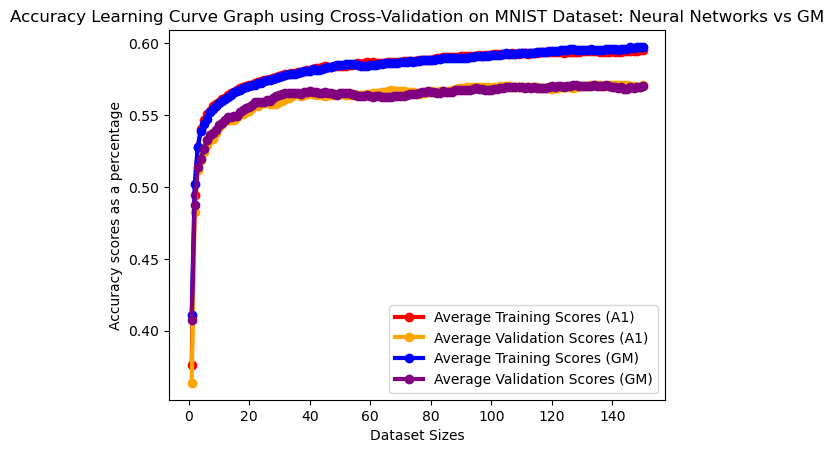

In [47]:
"""
Graphing the validation curves for both the baseline and the Dimension Reduced datasets.
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list_reg,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (A1)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list_reg,
    color="orange",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (A1)"
)

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list_gm,
    color="blue",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (GM)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list_gm,
    color="purple",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (GM)"
)

# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Accuracy scores as a percentage')
# Naming Title
plt.title("Accuracy Learning Curve Graph using Cross-Validation on MNIST Dataset: Neural Networks vs GM")

plt.legend()

plt.show()

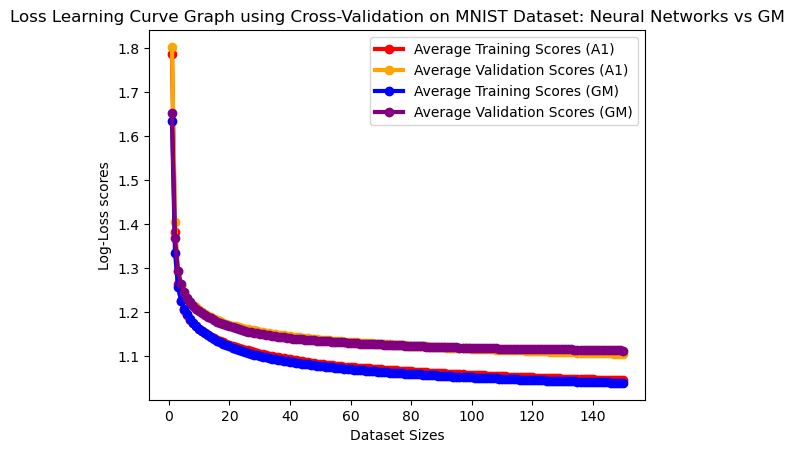

In [48]:
"""
Plotting the results into a loss learning curve graph
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_loss_values_reg,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (A1)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_loss_values_reg,
    color="orange",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (A1)"
)
# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_loss_values_gm,
    color="blue",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (GM)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_loss_values_gm,
    color="purple",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (GM)"
)


# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Log-Loss scores')
# Naming Title
plt.title("Loss Learning Curve Graph using Cross-Validation on MNIST Dataset: Neural Networks vs GM")

plt.legend()

plt.show()

In [49]:
"""
Running the KMeans clustering algorithm to find labels to add as another feature to the dataset
"""
init = "random"
n_init = 10
max_iter = 300
algorithm = "lloyd"

kmfinal = KMeans(
    n_clusters = 10,
    init = init,
    n_init = n_init,
    max_iter = max_iter,
    algorithm = algorithm,
    random_state = seed
)

kmfinal.fit(train_features)
kmeans_train_fit_labels = kmfinal.predict(train_features)
kmeans_test_fit_labels = kmfinal.predict(test_features)

In [50]:
"""
Adding the labels as a column to the train / test data KMeans
"""
kmeans_train_data = np.append(train_features, kmeans_train_fit_labels[:, None], axis=1)
kmeans_test_data = np.append(test_features, kmeans_test_fit_labels[:, None], axis=1)

In [51]:
"""
Actually training the MLP Classifier to generate the graph for the learning graph visualizer.
This should utilize the percentage of samples lists that use randomly selected samples of the
overall training data. This is so that we can test the accuracy (using cross-validation) across different
training data size samples to see at what point the accuracy score stops being affected by the size of the training
samples. This is also to see at what point the data might start getting overfit.

This is to generate the Accuracy Learning Curve.
"""
# Defining hyperparameters here
hidden_layer_sizes = [50, 10]
activation = 'relu'
learning_rate = 'constant'
max_iter = 1 # Setting this to 1 since we want to control the epochs ourselves
warm_start = True # This is to stack the training across different epochs

# lists to hold the results of training / validation scores
x_axis_list = []
avg_train_scores_list_kmeans = []
avg_validation_scores_list_kmeans = []
avg_train_loss_values_kmeans = []
avg_validation_loss_values_kmeans = []

# First declaring the Decision Tree Classifer from scikit-learn
clf = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    learning_rate=learning_rate,
    max_iter=max_iter,
    warm_start=warm_start,
    random_state=seed
)

for epoch_iteration in range(1, number_of_epochs + 1):
    
    # cross_val_score doesn't increase across epoch runs for some reason so I need to split it myself
    train_data, val_data, train_label, val_label = train_test_split(kmeans_train_data, train_labels, test_size=0.2, random_state=seed)
    
    clf.fit(train_data, train_label)
    
    accuracy_score = clf.score(train_data, train_label)
    validation_score = clf.score(val_data, val_label)
#     loss_score = clf.loss_
    train_loss_score = log_loss(train_label, clf.predict_proba(train_data))
    val_loss_score = log_loss(val_label, clf.predict_proba(val_data))
    
    x_axis_list.append(epoch_iteration)
    avg_train_scores_list_kmeans.append(accuracy_score)
    avg_validation_scores_list_kmeans.append(validation_score)
    avg_train_loss_values_kmeans.append(train_loss_score)
    avg_validation_loss_values_kmeans.append(val_loss_score)
    
    print("=============================================")
    print("Run for " + str(epoch_iteration) + " epoch")
    print("Training Score: " + str(accuracy_score))
    print("Validation Score: " + str(validation_score))
#     print("Loss Score: " + str(loss_score))
    print("Training Loss Score: " + str(train_loss_score))
    print("Validation Loss Score: " + str(val_loss_score))
    print("=============================================")



/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 1 epoch
Training Score: 0.39575492071327206
Validation Score: 0.39067127344521224
Training Loss Score: 1.730206318629224
Validation Loss Score: 1.7463963525900112


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 2 epoch
Training Score: 0.4828777688653051
Validation Score: 0.47297630799605134
Training Loss Score: 1.3784020629803326
Validation Loss Score: 1.4080616336038312


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 3 epoch
Training Score: 0.5149935213179491
Validation Score: 0.5077739387956565
Training Loss Score: 1.279895359698487
Validation Loss Score: 1.3168661501877212


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 4 epoch
Training Score: 0.5323934102548281
Validation Score: 0.5178923988153998
Training Loss Score: 1.2433843234077482
Validation Loss Score: 1.2829412679896244


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 5 epoch
Training Score: 0.5403837847843525
Validation Score: 0.5266535044422508
Training Loss Score: 1.2229835712895876
Validation Loss Score: 1.2625643298342215


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 6 epoch
Training Score: 0.5457209847596718
Validation Score: 0.5310957551826259
Training Loss Score: 1.2087222025351279
Validation Loss Score: 1.2479951525741952


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 7 epoch
Training Score: 0.549083729252792
Validation Score: 0.536771964461994
Training Loss Score: 1.198479240789105
Validation Loss Score: 1.2381395484370845


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 8 epoch
Training Score: 0.5514592460048128
Validation Score: 0.5381293188548865
Training Loss Score: 1.1894631379538967
Validation Loss Score: 1.2299253725321333


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 9 epoch
Training Score: 0.5540198679582896
Validation Score: 0.5414610069101679
Training Loss Score: 1.1818182978253202
Validation Loss Score: 1.2232422116143002


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 10 epoch
Training Score: 0.5556549639044858
Validation Score: 0.5417077986179665
Training Loss Score: 1.175031030023224
Validation Loss Score: 1.217491797328649


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 11 epoch
Training Score: 0.5566421916455853
Validation Score: 0.5410908193484699
Training Loss Score: 1.169088863604556
Validation Loss Score: 1.212562886508136


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 12 epoch
Training Score: 0.5580921823903252
Validation Score: 0.5430651530108588
Training Loss Score: 1.1635137851547837
Validation Loss Score: 1.2082001016574495


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 13 epoch
Training Score: 0.5591411118652434
Validation Score: 0.543928923988154
Training Loss Score: 1.1585545243205557
Validation Loss Score: 1.2045573991054357


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 14 epoch
Training Score: 0.5603751465416178
Validation Score: 0.5444225074037512
Training Loss Score: 1.154297999766338
Validation Loss Score: 1.201270134707982


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 15 epoch
Training Score: 0.5607453569445301
Validation Score: 0.5460266535044422
Training Loss Score: 1.1502024712206278
Validation Loss Score: 1.1980841669985978


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 16 epoch
Training Score: 0.5619485407539951
Validation Score: 0.5472606120434353
Training Loss Score: 1.1464828865722512
Validation Loss Score: 1.1954300987209838


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 17 epoch
Training Score: 0.56219534768927
Validation Score: 0.5476307996051333
Training Loss Score: 1.1429930397167347
Validation Loss Score: 1.1927496252499852


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 18 epoch
Training Score: 0.5644474609736534
Validation Score: 0.5484945705824285
Training Loss Score: 1.1394143731131532
Validation Loss Score: 1.189939883832648


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 19 epoch
Training Score: 0.5657431973838465
Validation Score: 0.5497285291214216
Training Loss Score: 1.13653359099919
Validation Loss Score: 1.1876028889123103


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 20 epoch
Training Score: 0.5664219164558524
Validation Score: 0.5493583415597236
Training Loss Score: 1.1337130518117369
Validation Loss Score: 1.1854432409699616


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 21 epoch
Training Score: 0.5677793545998643
Validation Score: 0.5488647581441264
Training Loss Score: 1.1310152709878938
Validation Loss Score: 1.1833449832297174


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 22 epoch
Training Score: 0.568612328006417
Validation Score: 0.549111549851925
Training Loss Score: 1.128594649113941
Validation Loss Score: 1.181394549625276


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 23 epoch
Training Score: 0.5694144505460603
Validation Score: 0.5493583415597236
Training Loss Score: 1.1263662955067735
Validation Loss Score: 1.1795469198181976


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 24 epoch
Training Score: 0.5696612574813352
Validation Score: 0.5515794669299111
Training Loss Score: 1.1241585175488429
Validation Loss Score: 1.1776340143687967


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 25 epoch
Training Score: 0.5699697661504288
Validation Score: 0.5530602171767028
Training Loss Score: 1.1221135143688288
Validation Loss Score: 1.1757367253719853


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 26 epoch
Training Score: 0.5706793360893441
Validation Score: 0.5529368213228035
Training Loss Score: 1.1201028790366743
Validation Loss Score: 1.1739756140261226


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 27 epoch
Training Score: 0.5711112482260752
Validation Score: 0.5525666337611056
Training Loss Score: 1.1182489261553576
Validation Loss Score: 1.1723960278668761


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 28 epoch
Training Score: 0.5716357129635343
Validation Score: 0.5528134254689042
Training Loss Score: 1.1165767806457345
Validation Loss Score: 1.1711063843828782


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 29 epoch
Training Score: 0.5724069846362683
Validation Score: 0.5538005923000987
Training Loss Score: 1.1147572916550292
Validation Loss Score: 1.1696011369226689


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 30 epoch
Training Score: 0.5726537915715432
Validation Score: 0.5536771964461994
Training Loss Score: 1.1131428323845391
Validation Loss Score: 1.1684159961750484


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 31 epoch
Training Score: 0.573579317578824
Validation Score: 0.555528134254689
Training Loss Score: 1.1115763024064038
Validation Loss Score: 1.1672701532072698


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 32 epoch
Training Score: 0.5741346331831925
Validation Score: 0.5550345508390918
Training Loss Score: 1.1099225048430892
Validation Loss Score: 1.16599466080661


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 33 epoch
Training Score: 0.5746590979206516
Validation Score: 0.5551579466929911
Training Loss Score: 1.1083683837065552
Validation Loss Score: 1.1648292944304988


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 34 epoch
Training Score: 0.5749984574566546
Validation Score: 0.5551579466929911
Training Loss Score: 1.1069709805926937
Validation Loss Score: 1.1638235390817984


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 35 epoch
Training Score: 0.5756154747948418
Validation Score: 0.5552813425468904
Training Loss Score: 1.1055277086546638
Validation Loss Score: 1.1627899347898174


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 36 epoch
Training Score: 0.5769112112050349
Validation Score: 0.555898321816387
Training Loss Score: 1.1041937840523417
Validation Loss Score: 1.1619744337661526


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 37 epoch
Training Score: 0.577435675942494
Validation Score: 0.5557749259624877
Training Loss Score: 1.1028050253920114
Validation Loss Score: 1.1608620345689382


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 38 epoch
Training Score: 0.5776824828777689
Validation Score: 0.5557749259624877
Training Loss Score: 1.1014516356227326
Validation Loss Score: 1.1598182275468025


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 39 epoch
Training Score: 0.5781760967483186
Validation Score: 0.5554047384007897
Training Loss Score: 1.1001922601452345
Validation Loss Score: 1.1587029857157163


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 40 epoch
Training Score: 0.5783920528166842
Validation Score: 0.5561451135241856
Training Loss Score: 1.098976971038272
Validation Loss Score: 1.1577168103840503


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 41 epoch
Training Score: 0.5788548158203245
Validation Score: 0.5566386969397829
Training Loss Score: 1.0978829831785932
Validation Loss Score: 1.1569918296084145


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 42 epoch
Training Score: 0.5795335348923305
Validation Score: 0.5560217176702863
Training Loss Score: 1.0967545513116521
Validation Loss Score: 1.156134751241388


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 43 epoch
Training Score: 0.5792558770901463
Validation Score: 0.555898321816387
Training Loss Score: 1.0956236042130953
Validation Loss Score: 1.1552188343442602


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 44 epoch
Training Score: 0.5798111926945148
Validation Score: 0.5557749259624877
Training Loss Score: 1.0946273094998973
Validation Loss Score: 1.1543934894654757


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 45 epoch
Training Score: 0.5795952366261492
Validation Score: 0.555898321816387
Training Loss Score: 1.0935841150845806
Validation Loss Score: 1.153479502972707


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 46 epoch
Training Score: 0.5796877892268772
Validation Score: 0.5557749259624877
Training Loss Score: 1.0925080803631473
Validation Loss Score: 1.1526483583918445


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 47 epoch
Training Score: 0.5802739556981551
Validation Score: 0.5568854886475815
Training Loss Score: 1.0915656916845473
Validation Loss Score: 1.151750622484717


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 48 epoch
Training Score: 0.5806750169679769
Validation Score: 0.557502467917078
Training Loss Score: 1.0906533485185088
Validation Loss Score: 1.1508238553420531


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 49 epoch
Training Score: 0.5810760782377985
Validation Score: 0.5576258637709773
Training Loss Score: 1.0897249130620237
Validation Loss Score: 1.1500197973878372


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 50 epoch
Training Score: 0.5810143765039798
Validation Score: 0.5579960513326753
Training Loss Score: 1.088897668023509
Validation Loss Score: 1.149157449324381


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 51 epoch
Training Score: 0.5812303325723452
Validation Score: 0.5586130306021717
Training Loss Score: 1.0881897454040204
Validation Loss Score: 1.1483958089556894


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 52 epoch
Training Score: 0.5812303325723452
Validation Score: 0.5599703849950641
Training Loss Score: 1.0874450879737685
Validation Loss Score: 1.1475155999539104


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 53 epoch
Training Score: 0.5809835256370705
Validation Score: 0.5602171767028628
Training Loss Score: 1.0867462060573299
Validation Loss Score: 1.1468550373435429


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 54 epoch
Training Score: 0.5814771395076201
Validation Score: 0.5613277393879565
Training Loss Score: 1.0860111480978059
Validation Loss Score: 1.146227390620133


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 55 epoch
Training Score: 0.581631393842167
Validation Score: 0.5612043435340572
Training Loss Score: 1.0853078607614748
Validation Loss Score: 1.1455297786210703


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 56 epoch
Training Score: 0.5820941568458073
Validation Score: 0.5604639684106614
Training Loss Score: 1.0844922696356623
Validation Loss Score: 1.1445952897853426


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 57 epoch
Training Score: 0.5824952181156291
Validation Score: 0.5613277393879565
Training Loss Score: 1.0838019257584224
Validation Loss Score: 1.1440471190514525


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 58 epoch
Training Score: 0.5828962793854507
Validation Score: 0.5615745310957552
Training Loss Score: 1.0829785316354197
Validation Loss Score: 1.1431648660513902


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 59 epoch
Training Score: 0.5828037267847227
Validation Score: 0.5609575518262586
Training Loss Score: 1.0821848686911026
Validation Loss Score: 1.1423801121915458


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 60 epoch
Training Score: 0.5825569198494478
Validation Score: 0.5615745310957552
Training Loss Score: 1.0816211139296061
Validation Loss Score: 1.1417468913169715


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 61 epoch
Training Score: 0.5830505337199975
Validation Score: 0.562314906219151
Training Loss Score: 1.080928013640307
Validation Loss Score: 1.1409858223927263


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 62 epoch
Training Score: 0.5835749984574566
Validation Score: 0.5630552813425469
Training Loss Score: 1.0801533513341417
Validation Loss Score: 1.1402173657256893


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 63 epoch
Training Score: 0.5832047880545443
Validation Score: 0.5647828232971372
Training Loss Score: 1.0795321320874223
Validation Loss Score: 1.1395126782400853


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 64 epoch
Training Score: 0.5834515949898192
Validation Score: 0.5645360315893386
Training Loss Score: 1.0788575234281057
Validation Loss Score: 1.138961729667531


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 65 epoch
Training Score: 0.5840069105941877
Validation Score: 0.5644126357354393
Training Loss Score: 1.0782641441572818
Validation Loss Score: 1.1383578620459471


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 66 epoch
Training Score: 0.5846239279323749
Validation Score: 0.5641658440276407
Training Loss Score: 1.077692382684171
Validation Loss Score: 1.1378511063191374


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 67 epoch
Training Score: 0.5847473314000123
Validation Score: 0.5647828232971372
Training Loss Score: 1.0770324222928163
Validation Loss Score: 1.1372041158777648


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 68 epoch
Training Score: 0.584716480533103
Validation Score: 0.5649062191510366
Training Loss Score: 1.076463004206965
Validation Loss Score: 1.13667161263955


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 69 epoch
Training Score: 0.5851792435367433
Validation Score: 0.5645360315893386
Training Loss Score: 1.0759829488041615
Validation Loss Score: 1.1362708351667197


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 70 epoch
Training Score: 0.5851175418029246
Validation Score: 0.5640424481737414
Training Loss Score: 1.0754253085247807
Validation Loss Score: 1.135758181185059


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 71 epoch
Training Score: 0.5854877522058369
Validation Score: 0.56428923988154
Training Loss Score: 1.0748952818777113
Validation Loss Score: 1.135248873832556


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 72 epoch
Training Score: 0.5856111556734744
Validation Score: 0.5631786771964462
Training Loss Score: 1.0745273743573969
Validation Loss Score: 1.1347421374623


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 73 epoch
Training Score: 0.5860122169432961
Validation Score: 0.5633020730503455
Training Loss Score: 1.07396392149684
Validation Loss Score: 1.134160976702797


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 74 epoch
Training Score: 0.585919664342568
Validation Score: 0.562685093780849
Training Loss Score: 1.0734882015935971
Validation Loss Score: 1.1335374594533594


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 75 epoch
Training Score: 0.5860122169432961
Validation Score: 0.5633020730503455
Training Loss Score: 1.07298712894118
Validation Loss Score: 1.1329293573216246


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 76 epoch
Training Score: 0.585919664342568
Validation Score: 0.5636722606120435
Training Loss Score: 1.072402623071035
Validation Loss Score: 1.1321917990970476


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 77 epoch
Training Score: 0.5863207256123897
Validation Score: 0.5644126357354393
Training Loss Score: 1.071860572143723
Validation Loss Score: 1.1316852134188091


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 78 epoch
Training Score: 0.5861356204109336
Validation Score: 0.56428923988154
Training Loss Score: 1.0713081293416742
Validation Loss Score: 1.1310853917016777


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 79 epoch
Training Score: 0.5860430678102054
Validation Score: 0.5647828232971372
Training Loss Score: 1.0709197289583483
Validation Loss Score: 1.1305584836573694


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 80 epoch
Training Score: 0.5861973221447523
Validation Score: 0.5656465942744324
Training Loss Score: 1.0704516529135715
Validation Loss Score: 1.1300275918521347


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 81 epoch
Training Score: 0.5868760412167582
Validation Score: 0.5661401776900297
Training Loss Score: 1.0699004551899187
Validation Loss Score: 1.1294305273938656


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 82 epoch
Training Score: 0.5869377429505769
Validation Score: 0.565893385982231
Training Loss Score: 1.0694081219888427
Validation Loss Score: 1.1287406940579914


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 83 epoch
Training Score: 0.5870611464182144
Validation Score: 0.566263573543929
Training Loss Score: 1.0689725270544994
Validation Loss Score: 1.1282771844376636


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 84 epoch
Training Score: 0.5871845498858518
Validation Score: 0.5666337611056268
Training Loss Score: 1.0684414989249713
Validation Loss Score: 1.1277456388790061


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 85 epoch
Training Score: 0.587462207688036
Validation Score: 0.5665103652517275
Training Loss Score: 1.0681093948076748
Validation Loss Score: 1.1274528156452714


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 86 epoch
Training Score: 0.5876781637564016
Validation Score: 0.567127344521224
Training Loss Score: 1.0676749741396085
Validation Loss Score: 1.1270080819505308


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 87 epoch
Training Score: 0.587801567224039
Validation Score: 0.566263573543929
Training Loss Score: 1.0672949212477412
Validation Loss Score: 1.1267459698166298


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 88 epoch
Training Score: 0.5879558215585858
Validation Score: 0.5656465942744324
Training Loss Score: 1.0668291302519406
Validation Loss Score: 1.126238271033764


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 89 epoch
Training Score: 0.587801567224039
Validation Score: 0.565893385982231
Training Loss Score: 1.066410796543974
Validation Loss Score: 1.1260782316366704


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 90 epoch
Training Score: 0.5878632689578577
Validation Score: 0.5655231984205331
Training Loss Score: 1.066027260519357
Validation Loss Score: 1.1256369526784784


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 91 epoch
Training Score: 0.5884185845622262
Validation Score: 0.5649062191510366
Training Loss Score: 1.0655493280636503
Validation Loss Score: 1.1254362592525762


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 92 epoch
Training Score: 0.5887887949651385
Validation Score: 0.565893385982231
Training Loss Score: 1.065059551811909
Validation Loss Score: 1.1248370070336478


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 93 epoch
Training Score: 0.588572838896773
Validation Score: 0.5646594274432379
Training Loss Score: 1.0646323317547683
Validation Loss Score: 1.124404376661164


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 94 epoch
Training Score: 0.5887579440982291
Validation Score: 0.5650296150049359
Training Loss Score: 1.0641424675458908
Validation Loss Score: 1.1239193690669498


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 95 epoch
Training Score: 0.5888196458320479
Validation Score: 0.5647828232971372
Training Loss Score: 1.0637216993471532
Validation Loss Score: 1.1234640576335981


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 96 epoch
Training Score: 0.5888504966989573
Validation Score: 0.566263573543929
Training Loss Score: 1.063291859896276
Validation Loss Score: 1.123021664298427


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 97 epoch
Training Score: 0.5894675140371445
Validation Score: 0.5661401776900297
Training Loss Score: 1.0628719380857
Validation Loss Score: 1.1226884527805627


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 98 epoch
Training Score: 0.5890973036342321
Validation Score: 0.5667571569595261
Training Loss Score: 1.0624943518733667
Validation Loss Score: 1.1223442028908954


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 99 epoch
Training Score: 0.5893749614364163
Validation Score: 0.5668805528134254
Training Loss Score: 1.062072254350591
Validation Loss Score: 1.121862524750831


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 100 epoch
Training Score: 0.5891898562349602
Validation Score: 0.5670039486673247
Training Loss Score: 1.061681029667287
Validation Loss Score: 1.1214756327391393


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 101 epoch
Training Score: 0.5892207071018696
Validation Score: 0.5670039486673247
Training Loss Score: 1.061302535499078
Validation Loss Score: 1.1211257116126796


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 102 epoch
Training Score: 0.5895909175047819
Validation Score: 0.5672507403751234
Training Loss Score: 1.060897321213756
Validation Loss Score: 1.1207795030676906


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 103 epoch
Training Score: 0.5904855926451533
Validation Score: 0.5676209279368213
Training Loss Score: 1.0606082358509588
Validation Loss Score: 1.1206515334989524


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 104 epoch
Training Score: 0.5909483556487938
Validation Score: 0.5676209279368213
Training Loss Score: 1.060173908907012
Validation Loss Score: 1.1202811884856914


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 105 epoch
Training Score: 0.5906706978466095
Validation Score: 0.5677443237907206
Training Loss Score: 1.0598543037404173
Validation Loss Score: 1.1198947074610057


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 106 epoch
Training Score: 0.5907323995804282
Validation Score: 0.5677443237907206
Training Loss Score: 1.0594824872580537
Validation Loss Score: 1.1195851661344989


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 107 epoch
Training Score: 0.5904238909113346
Validation Score: 0.5684846989141165
Training Loss Score: 1.0592423850672665
Validation Loss Score: 1.1194036659367732


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 108 epoch
Training Score: 0.590547294378972
Validation Score: 0.569101678183613
Training Loss Score: 1.058951106762149
Validation Loss Score: 1.119092175528094


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 109 epoch
Training Score: 0.590547294378972
Validation Score: 0.5699654491609082
Training Loss Score: 1.0586617250231831
Validation Loss Score: 1.1187944630566211


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 110 epoch
Training Score: 0.5906706978466095
Validation Score: 0.5700888450148075
Training Loss Score: 1.0583662939275487
Validation Loss Score: 1.1185449082939396


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 111 epoch
Training Score: 0.5903930400444253
Validation Score: 0.5709526159921027
Training Loss Score: 1.058029549778957
Validation Loss Score: 1.1181491615372143


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 112 epoch
Training Score: 0.5907632504473376
Validation Score: 0.5708292201382034
Training Loss Score: 1.057803789424637
Validation Loss Score: 1.1179134551871823


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 113 epoch
Training Score: 0.5910409082495218
Validation Score: 0.5703356367226061
Training Loss Score: 1.0575316651807714
Validation Loss Score: 1.1175729407246344


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 114 epoch
Training Score: 0.5907941013142469
Validation Score: 0.570705824284304
Training Loss Score: 1.0573175228181209
Validation Loss Score: 1.1173354746399533


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 115 epoch
Training Score: 0.5910100573826125
Validation Score: 0.5703356367226061
Training Loss Score: 1.0569873513203827
Validation Loss Score: 1.1169126034108192


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 116 epoch
Training Score: 0.5910409082495218
Validation Score: 0.5708292201382034
Training Loss Score: 1.0566944147241055
Validation Loss Score: 1.1165092075725778


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 117 epoch
Training Score: 0.5911334608502499
Validation Score: 0.5704590325765054
Training Loss Score: 1.0564953418091623
Validation Loss Score: 1.1162199751509414


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 118 epoch
Training Score: 0.591657925587709
Validation Score: 0.569471865745311
Training Loss Score: 1.0562631744994226
Validation Loss Score: 1.1159828528757607


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 119 epoch
Training Score: 0.5913494169186154
Validation Score: 0.5700888450148075
Training Loss Score: 1.0559013247824427
Validation Loss Score: 1.1155878257390777


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 120 epoch
Training Score: 0.5917504781884371
Validation Score: 0.5688548864758144
Training Loss Score: 1.0555644587671444
Validation Loss Score: 1.1153651276456753


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 121 epoch
Training Score: 0.591226013450978
Validation Score: 0.5678677196446199
Training Loss Score: 1.0553331497262706
Validation Loss Score: 1.1152288729631024


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 122 epoch
Training Score: 0.5914111186524341
Validation Score: 0.5666337611056268
Training Loss Score: 1.0549885082072497
Validation Loss Score: 1.1149583834264993


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 123 epoch
Training Score: 0.5915345221200716
Validation Score: 0.5667571569595261
Training Loss Score: 1.0547247278864527
Validation Loss Score: 1.114671057960564


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 124 epoch
Training Score: 0.5910717591164312
Validation Score: 0.5668805528134254
Training Loss Score: 1.0544856267288927
Validation Loss Score: 1.1144342657700292


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 125 epoch
Training Score: 0.5910100573826125
Validation Score: 0.5663869693978283
Training Loss Score: 1.0541324473213494
Validation Loss Score: 1.1141766387929968


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 126 epoch
Training Score: 0.5913185660517061
Validation Score: 0.5670039486673247
Training Loss Score: 1.0537217633371727
Validation Loss Score: 1.113886511732179


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 127 epoch
Training Score: 0.5907632504473376
Validation Score: 0.5673741362290227
Training Loss Score: 1.0535382525412407
Validation Loss Score: 1.1137735041283074


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 128 epoch
Training Score: 0.5906706978466095
Validation Score: 0.5670039486673247
Training Loss Score: 1.0534178987770082
Validation Loss Score: 1.1136684240432915


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 129 epoch
Training Score: 0.5911334608502499
Validation Score: 0.5670039486673247
Training Loss Score: 1.0530700867418734
Validation Loss Score: 1.1133190378135658


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 130 epoch
Training Score: 0.5907632504473376
Validation Score: 0.5676209279368213
Training Loss Score: 1.05291094725312
Validation Loss Score: 1.1133063678291972


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 131 epoch
Training Score: 0.5907632504473376
Validation Score: 0.5672507403751234
Training Loss Score: 1.052684771041085
Validation Loss Score: 1.1131400472206427


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 132 epoch
Training Score: 0.590886653914975
Validation Score: 0.567127344521224
Training Loss Score: 1.0524332137069896
Validation Loss Score: 1.1128062134472154


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 133 epoch
Training Score: 0.591226013450978
Validation Score: 0.567127344521224
Training Loss Score: 1.0522449914304248
Validation Loss Score: 1.1126131063102023


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 134 epoch
Training Score: 0.5912568643178874
Validation Score: 0.5665103652517275
Training Loss Score: 1.0519596336829182
Validation Loss Score: 1.1123637268227853


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 135 epoch
Training Score: 0.5915962238538903
Validation Score: 0.5668805528134254
Training Loss Score: 1.051684061931676
Validation Loss Score: 1.1121154038501544


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 136 epoch
Training Score: 0.5917504781884371
Validation Score: 0.5660167818361304
Training Loss Score: 1.0515216750490979
Validation Loss Score: 1.1119689117457205


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 137 epoch
Training Score: 0.5918430307891652
Validation Score: 0.5657699901283317
Training Loss Score: 1.051201606474737
Validation Loss Score: 1.111657690343948


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 138 epoch
Training Score: 0.5919047325229839
Validation Score: 0.5660167818361304
Training Loss Score: 1.0509644438498729
Validation Loss Score: 1.1115104612782998


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 139 epoch
Training Score: 0.5915962238538903
Validation Score: 0.5665103652517275
Training Loss Score: 1.0506490550295011
Validation Loss Score: 1.1112140020940493


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 140 epoch
Training Score: 0.5915345221200716
Validation Score: 0.5668805528134254
Training Loss Score: 1.0505124427487296
Validation Loss Score: 1.1110633754367174


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 141 epoch
Training Score: 0.5915962238538903
Validation Score: 0.566263573543929
Training Loss Score: 1.0502649895803262
Validation Loss Score: 1.1108220348529332


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 142 epoch
Training Score: 0.5920281359906213
Validation Score: 0.5665103652517275
Training Loss Score: 1.050109240219252
Validation Loss Score: 1.1107191782943475


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 143 epoch
Training Score: 0.5918430307891652
Validation Score: 0.5660167818361304
Training Loss Score: 1.0499140432095786
Validation Loss Score: 1.1106202176267106


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 144 epoch
Training Score: 0.5919047325229839
Validation Score: 0.5660167818361304
Training Loss Score: 1.0495424452436408
Validation Loss Score: 1.110315010519897


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 145 epoch
Training Score: 0.59208983772444
Validation Score: 0.5661401776900297
Training Loss Score: 1.0494215971404486
Validation Loss Score: 1.1101580050148772


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 146 epoch
Training Score: 0.5917196273215277
Validation Score: 0.565893385982231
Training Loss Score: 1.0491889425526129
Validation Loss Score: 1.1099868651607818


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 147 epoch
Training Score: 0.5923983463935336
Validation Score: 0.5665103652517275
Training Loss Score: 1.049084097672905
Validation Loss Score: 1.109856514703868


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 148 epoch
Training Score: 0.592429197260443
Validation Score: 0.5665103652517275
Training Loss Score: 1.0488865143886792
Validation Loss Score: 1.109606877746304


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Run for 149 epoch
Training Score: 0.5919355833898933
Validation Score: 0.565893385982231
Training Loss Score: 1.0486292735407392
Validation Loss Score: 1.109464524864746
Run for 150 epoch
Training Score: 0.5921515394582588
Validation Score: 0.5661401776900297
Training Loss Score: 1.0484725343659933
Validation Loss Score: 1.109121563084212


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [52]:
"""
Computing Accuracy Score on the Test data KMeans
"""

clf = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    learning_rate=learning_rate,
    max_iter=number_of_epochs,
    warm_start=warm_start,
    random_state=seed
)

clf.fit(kmeans_train_data, train_labels)
start_time = time.time()
score = clf.score(kmeans_test_data, test_labels)
training_time = time.time() - start_time
print(score)
print(training_time)

0.5735228787205686
0.0045871734619140625


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


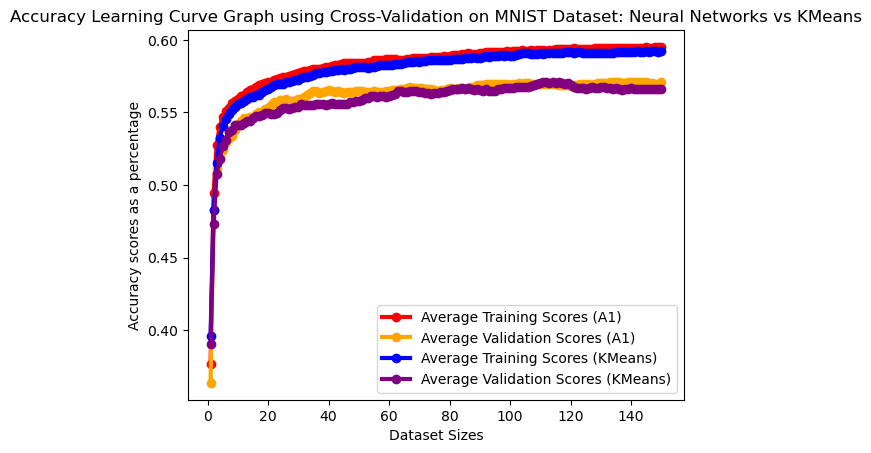

In [53]:
"""
Graphing the validation curves for both the baseline and the Dimension Reduced datasets.
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list_reg,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (A1)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list_reg,
    color="orange",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (A1)"
)

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list_kmeans,
    color="blue",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (KMeans)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list_kmeans,
    color="purple",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (KMeans)"
)

# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Accuracy scores as a percentage')
# Naming Title
plt.title("Accuracy Learning Curve Graph using Cross-Validation on MNIST Dataset: Neural Networks vs KMeans")

plt.legend()

plt.show()

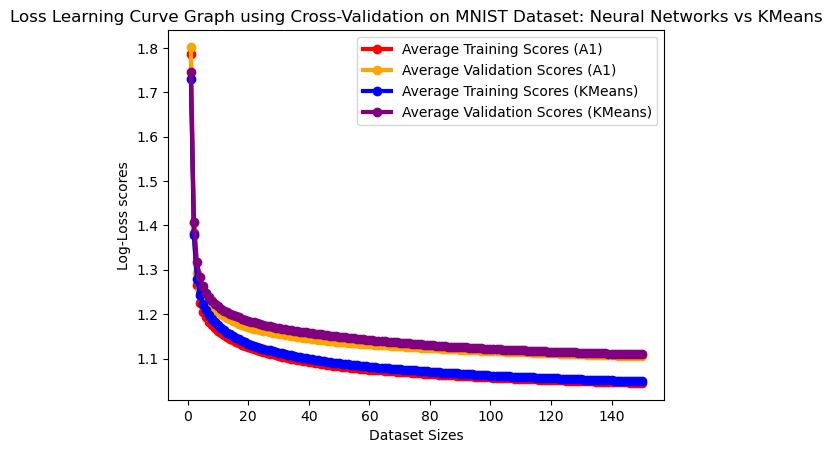

In [54]:
"""
Plotting the results into a loss learning curve graph
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_loss_values_reg,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (A1)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_loss_values_reg,
    color="orange",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (A1)"
)
# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_loss_values_kmeans,
    color="blue",
    linewidth=3,
    marker='o',
    label = "Average Training Scores (KMeans)"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_loss_values_kmeans,
    color="purple",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores (KMeans)"
)


# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Log-Loss scores')
# Naming Title
plt.title("Loss Learning Curve Graph using Cross-Validation on MNIST Dataset: Neural Networks vs KMeans")

plt.legend()

plt.show()